# Identitas Diri
Nama : Indiarto Aji Begawan \
Email : indiartoaji13@gmail.com \
Learning Path : Belajar Pengembangan Machine Learning\
Materi : Proyek Pertama - Membuat Model NLP dengan TensorFlow

# Library

In [134]:
import re
import nltk
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout, LSTM

# Cleaning Text (Function)
(https://stackoverflow.com/questions/54733828/remove-twitter-mentions-from-pandas-column)

In [135]:
def clean_text(row, options):

    if options['lowercase']:
        row = row.lower()

    if options['remove_url']:
        row = row.replace('http\S+|www.\S+|.com\S+', '')

    if options['remove_mentions']:
        row = re.sub("@[A-Za-z0-9_]+","", row)

    if options['remove_hastags']:
        row = re.sub("#+","", row)

    return row

clean_config = {
    'remove_url': True,
    'remove_mentions': True,
    'lowercase': True,
    'remove_hastags' : True
    }

In [136]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Corona Dataset

In [195]:
df = pd.read_csv('Corona_NLP_test.csv').dropna()
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
...,...,...,...,...,...,...
3792,3793,48745,Washington D.C.,16-03-2020,"@RicePolitics @MDCounties Craig, will you call...",Negative
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral


Dataset merupakan data publik yang diambil dari situs Kaggle dengfan nama Coronavirus tweets NLP - Text Classification (https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification) yang berisikan 3798 data dan 6 kolom.

In [196]:
df = df.drop(columns=['UserName', 'ScreenName','Location', 'TweetAt'])
df

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,Do you remember the last time you paid $2.99 a...,Neutral
...,...,...
3792,"@RicePolitics @MDCounties Craig, will you call...",Negative
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2964 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  2964 non-null   object
 1   Sentiment      2964 non-null   object
dtypes: object(2)
memory usage: 69.5+ KB


Kolom yang diambil hanyalah kolom OriginalTweet dan Sentiment. Kolom OriginalTweet akan menjadi data masukan dan kolom Sentiment akan menjadi label.

In [198]:
df.loc[df.Sentiment == "Extremely Negative","Sentiment"] = "Negative"
df.loc[df.Sentiment == "Extremely Positive","Sentiment"] = "Positive"
df

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,Do you remember the last time you paid $2.99 a...,Neutral
...,...,...
3792,"@RicePolitics @MDCounties Craig, will you call...",Negative
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral


Terdapat 5 label yaitu Extremely Negative, negative, Neutral, Positive, dan Extremely Positive. Label Extremely Negative dilebur menjadi Negative dan Extremely Positive dilebur menjadi Positive. Hasilnya hanya ada 3 label yaitu negative, Neutral, dan Positive.

In [199]:
category = pd.get_dummies(df.Sentiment)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Sentiment')
df_baru

,OriginalTweet,Negative,Neutral,Positive
0,TRENDING: New Yorkers encounter empty supermar...,1,0,0
1,When I couldn't find hand sanitizer at Fred Me...,0,0,1
3,#Panic buying hits #NewYork City as anxious sh...,1,0,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0,1,0
5,Do you remember the last time you paid $2.99 a...,0,1,0
...,...,...,...,...
3792,"@RicePolitics @MDCounties Craig, will you call...",1,0,0
3793,Meanwhile In A Supermarket in Israel -- People...,0,0,1
3794,Did you panic buy a lot of non-perishable item...,1,0,0
3795,Asst Prof of Economics @cconces was on @NBCPhi...,0,1,0


Label diubah menjadi data biner untuk memudahkan dalam identifikasi oleh machine.

In [200]:
df_baru['tweet'] = df_baru['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_baru['tweet'] = df_baru['tweet'].apply(clean_text, args=(clean_config,))
# df_baru["tweet"] = df_baru['tweet'].str.replace('[^\w\s]','')
df_baru

,OriginalTweet,Negative,Neutral,Positive,tweet
0,TRENDING: New Yorkers encounter empty supermar...,1,0,0,trending: new yorkers encounter empty supermar...
1,When I couldn't find hand sanitizer at Fred Me...,0,0,1,"when i find hand sanitizer fred meyer, i turne..."
3,#Panic buying hits #NewYork City as anxious sh...,1,0,0,panic buying hits newyork city anxious shopper...
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0,1,0,toiletpaper dunnypaper coronavirus coronavirus...
5,Do you remember the last time you paid $2.99 a...,0,1,0,do remember last time paid $2.99 gallon regula...
...,...,...,...,...,...
3792,"@RicePolitics @MDCounties Craig, will you call...",1,0,0,"craig, call general assembly enact legal sta..."
3793,Meanwhile In A Supermarket in Israel -- People...,0,0,1,meanwhile in a supermarket israel -- people da...
3794,Did you panic buy a lot of non-perishable item...,1,0,0,did panic buy lot non-perishable items? echo n...
3795,Asst Prof of Economics @cconces was on @NBCPhi...,0,1,0,asst prof economics talking recent research ...


Data masukan diproses untuk menghilangkan stop word(English). Data masukan diproses menggunakan fungsi clean_data untuk menghilangkan URL, Mention, Hastags, dan mengubah kalimat menjadi lower case.

In [201]:
tweet = df_baru['tweet'].values
label = df_baru[['Negative', 'Neutral', 'Positive']].values
num_classes = len(label[0])

Data dalam dataframe diubah menjadi bentuk array dalam variabel tweet(data masukan) dan label.

In [202]:
x_train, x_test, y_train, y_test = train_test_split(tweet, label, test_size=0.2)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

2371
2371
593
593


Data tersebut kemudian displit menjadi data latih dan data tes.

In [203]:
max_kata = 60

token = Tokenizer(num_words=15000,oov_token='-')
token.fit_on_texts(x_train)
token.fit_on_texts(x_test)

x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = max_kata, padding="post") 
x_test = pad_sequences(x_test, maxlen = max_kata, padding="post") 


Masing-masing kalimat diubah menjadi angka dengan menggunakan fungsi Tokenizer.

In [204]:
token.index_word
vocab = len(token.index_word)+1
vocab

11461

Mengukur banyak kata yang ada pada data masukan.

In [205]:
vec_size=300
model = Sequential()
model.add(Embedding(vocab, vec_size, input_length = max_kata))
model.add(LSTM(128))
model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 60, 300)           3438300   
                                                                 
 lstm_22 (LSTM)              (None, 128)               219648    
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 3)                 387       
                                                                 
Total params: 3,658,335
Trainable params: 3,658,335
Non-trainable params: 0
_________________________________________________________________


Membangun model untuk proses training menggunakan metode LSTM.

In [206]:
hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), verbose=2)

Epoch 1/50
75/75 - 3s - loss: 1.0376 - accuracy: 0.4163 - val_loss: 1.0452 - val_accuracy: 0.4115 - 3s/epoch - 34ms/step
Epoch 2/50
75/75 - 1s - loss: 1.0319 - accuracy: 0.4209 - val_loss: 1.0449 - val_accuracy: 0.4047 - 609ms/epoch - 8ms/step
Epoch 3/50
75/75 - 1s - loss: 1.0310 - accuracy: 0.4336 - val_loss: 1.0443 - val_accuracy: 0.4047 - 609ms/epoch - 8ms/step
Epoch 4/50
75/75 - 1s - loss: 1.0324 - accuracy: 0.4159 - val_loss: 1.0470 - val_accuracy: 0.4115 - 728ms/epoch - 10ms/step
Epoch 5/50
75/75 - 1s - loss: 1.0281 - accuracy: 0.4213 - val_loss: 1.0433 - val_accuracy: 0.4047 - 1s/epoch - 13ms/step
Epoch 6/50
75/75 - 1s - loss: 1.0307 - accuracy: 0.4015 - val_loss: 1.0445 - val_accuracy: 0.4047 - 622ms/epoch - 8ms/step
Epoch 7/50
75/75 - 1s - loss: 1.0319 - accuracy: 0.3994 - val_loss: 1.0423 - val_accuracy: 0.4115 - 605ms/epoch - 8ms/step
Epoch 8/50
75/75 - 1s - loss: 1.0177 - accuracy: 0.4424 - val_loss: 1.0092 - val_accuracy: 0.4081 - 601ms/epoch - 8ms/step
Epoch 9/50
75/75 - 

Proses training sebanyak 30 epochs tetapi menghasilkan model yang overfitting karena nilai akurasi pada train data lebih besar dari akurasi pada validation data.

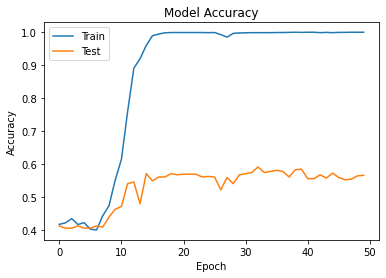

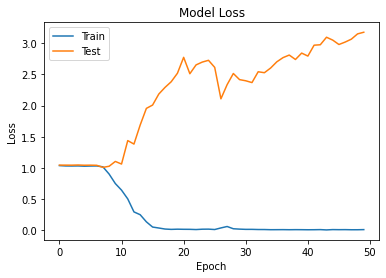

In [207]:
# Grafik Accuracy dan Validation Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Grafik Accuracy dan Validation Accuracy
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Terlihat pada grafik bahwa nilai akurasi pada test data berada jauh dibawah train data. Terdapat beberapa hipotesa mengenai hal tersebut salah satunya adalah jumlah data yang sangat sedikit yaitu sekitar 2000an. Untuk memperbaiki hal tersebut, saya telah mencoba beberapa parameter seperti merubah vec_size dan nilai LSTM tetapi tidak memberikan improvement yang signifinak. Nilai LSTM ini dipilih dengan mempertimbangkan waktu training, nilai akurasi (train dan val data), dan improvement pada tiap epoch.

# Emotion Dataset

In [208]:
df1 = pd.read_csv('emotion-labels-train.csv').dropna()
df2 = pd.read_csv('emotion-labels-test.csv').dropna()
df3 = pd.read_csv('emotion-labels-val.csv').dropna()
df = pd.concat([df1, df2, df3], axis=0)
df

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
342,Common app just randomly logged me out as I wa...,sadness
343,"I'd rather laugh with the rarest genius, in be...",sadness
344,If you #invest in my new #film I will stop ask...,sadness
345,"Just watched Django Unchained, Other people ma...",sadness


Untuk memperbaiki permasalahan pada dataset sebelumnya maka saya mencari dataset baru pada Kaggle dengan nama Emotion Classification NLP (https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-val.csv).
Data yang diperoleh telah dibagi menjadi data train, test, dan data validation. Disini saya menggabungkan data tersebut menjadi dataset yang utuh dan kemudian menggunakan fungsi train_test_split untuk membagi data menjadi data train dan test. Hal tersebut dilakukan untuk menanggulangi hipotesis pada dataset sebelumnya yaitu dataset yang sedikit. Jumlah data pada dataset ini adalah 7102 data setelah menghilangkan nilai Null menggunakan lib pandas.

In [209]:
label = pd.get_dummies(df.label)
df_baru = pd.concat([df, label], axis=1)
df_baru = df_baru.drop(columns='label')
df_baru

,text,anger,fear,joy,sadness
0,Just got back from seeing @GaryDelaney in Burs...,0,0,1,0
1,Oh dear an evening of absolute hilarity I don'...,0,0,1,0
2,Been waiting all week for this game ❤️❤️❤️ #ch...,0,0,1,0
3,"@gardiner_love : Thank you so much, Gloria! Yo...",0,0,1,0
4,I feel so blessed to work with the family that...,0,0,1,0
...,...,...,...,...,...
342,Common app just randomly logged me out as I wa...,0,0,0,1
343,"I'd rather laugh with the rarest genius, in be...",0,0,0,1
344,If you #invest in my new #film I will stop ask...,0,0,0,1
345,"Just watched Django Unchained, Other people ma...",0,0,0,1


Proses diatas bertujuan untuk mengubah label yang berupa string menjadi nilai biner yang dapat diproses oleh mesin.

In [210]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7102 entries, 0 to 346
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     7102 non-null   object
 1   anger    7102 non-null   uint8 
 2   fear     7102 non-null   uint8 
 3   joy      7102 non-null   uint8 
 4   sadness  7102 non-null   uint8 
dtypes: object(1), uint8(4)
memory usage: 138.7+ KB


df.info() berguna untuk menampilkan detail mengenaik dataframe yang akan di proses.

In [211]:
df_baru['tweet'] = df_baru['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_baru['tweet'] = df_baru['tweet'].apply(clean_text, args=(clean_config,))
df_baru["tweet"] = df_baru['tweet'].str.replace('[^\w\s]','')
df_baru

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,anger,fear,joy,sadness,tweet
0,Just got back from seeing @GaryDelaney in Burs...,0,0,1,0,just got back seeing burslem amazing face sti...
1,Oh dear an evening of absolute hilarity I don'...,0,0,1,0,oh dear evening absolute hilarity i think i la...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,0,0,1,0,been waiting week game cheer friday
3,"@gardiner_love : Thank you so much, Gloria! Yo...",0,0,1,0,thank much gloria youre sweet thoughtful you...
4,I feel so blessed to work with the family that...,0,0,1,0,i feel blessed work family i nanny nothing lo...
...,...,...,...,...,...,...
342,Common app just randomly logged me out as I wa...,0,0,0,1,common app randomly logged i writing last part...
343,"I'd rather laugh with the rarest genius, in be...",0,0,0,1,id rather laugh rarest genius beautiful allian...
344,If you #invest in my new #film I will stop ask...,0,0,0,1,if invest new film i stop asking invest new fi...
345,"Just watched Django Unchained, Other people ma...",0,0,0,1,just watched django unchained other people may...


Seperti yang telah dijelaskan pada dataset sebelumnya, function clean_text berguna untuk menghilangkan mention, website, hastags, dan dibuat lower case.

In [212]:
tweet = df_baru['tweet'].values
label = df_baru[['anger', 'fear', 'joy', 'sadness']].values
num_classes = len(label[0])

Block diatas bertujuan untuk membagi data masukan dan label.

In [213]:
x_train, x_test, y_train, y_test = train_test_split(tweet, label, test_size=0.2)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

5681
5681
1421
1421


function diatas digunakan untuk membagi data train dan test dengan rasio 8:2.

In [214]:
max_kata = 30

token = Tokenizer(num_words=15000,oov_token='-')
token.fit_on_texts(x_train)
token.fit_on_texts(x_test)

x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen = max_kata, padding="post") 
x_test = pad_sequences(x_test, maxlen = max_kata, padding="post") 


block diatas bertujuan untuk mengidentifikasi kata menjadi urutan angka untuk mempermudah mesin untuk proses identifikasi.

In [215]:
token.index_word
vocab = len(token.index_word)+1
vocab

13345

terdapat 13344 vocabulary pada data tersebut.

In [216]:
vec_size=300
model = Sequential()
model.add(Embedding(vocab, vec_size, input_length = max_kata))
model.add(LSTM(256))
model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 30, 300)           4003500   
                                                                 
 lstm_23 (LSTM)              (None, 256)               570368    
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 4,574,896
Trainable params: 4,574,896
Non-trainable params: 0
_________________________________________________________________


Model yang dibuat sama seperti yang digunakan pada dataset sebelumnya.

In [217]:
histo = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), verbose=2)

Epoch 1/30
178/178 - 4s - loss: 1.3808 - accuracy: 0.3042 - val_loss: 1.3660 - val_accuracy: 0.3300 - 4s/epoch - 21ms/step
Epoch 2/30
178/178 - 1s - loss: 0.8901 - accuracy: 0.6296 - val_loss: 0.6461 - val_accuracy: 0.7959 - 1s/epoch - 7ms/step
Epoch 3/30
178/178 - 1s - loss: 0.3464 - accuracy: 0.8983 - val_loss: 0.4610 - val_accuracy: 0.8557 - 1s/epoch - 7ms/step
Epoch 4/30
178/178 - 1s - loss: 0.2106 - accuracy: 0.9433 - val_loss: 0.4897 - val_accuracy: 0.8783 - 1s/epoch - 7ms/step
Epoch 5/30
178/178 - 1s - loss: 0.1506 - accuracy: 0.9560 - val_loss: 0.5914 - val_accuracy: 0.8550 - 1s/epoch - 7ms/step
Epoch 6/30
178/178 - 1s - loss: 0.1116 - accuracy: 0.9629 - val_loss: 0.5211 - val_accuracy: 0.8768 - 1s/epoch - 7ms/step
Epoch 7/30
178/178 - 1s - loss: 0.0942 - accuracy: 0.9662 - val_loss: 0.6750 - val_accuracy: 0.8346 - 1s/epoch - 7ms/step
Epoch 8/30
178/178 - 1s - loss: 0.0835 - accuracy: 0.9669 - val_loss: 0.6660 - val_accuracy: 0.8642 - 1s/epoch - 7ms/step
Epoch 9/30
178/178 - 1s

Proses training dilakukan sebanyak 30 epoch dan menghasilkan nilai akurasi yang jauh lebih baik yaitu untuk data train dan test yaitu kurang lebih 97% dan 87%.

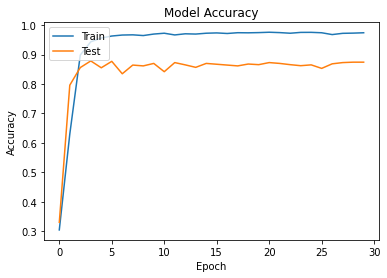

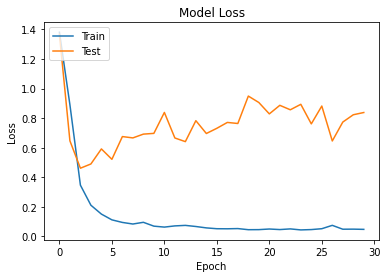

In [218]:
# Grafik Accuracy dan Validation Accuracy
plt.plot(histo.history['accuracy'])
plt.plot(histo.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Grafik Accuracy dan Validation Accuracy
plt.plot(histo.history['loss'])
plt.plot(histo.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Grafik diatas menunjukan Akurasi dan Loss. Nilai akurasi pada train dan test memiliki selisih yang cukup kecil dibanding pada dataset sebelumnya yaitu +- 10%.
Selain itu pada nilai loss, terdapat perbedaan yang sangat signifikan yaitu pada train loss cenderung kovergen dan semakin mendekati nilai nol sedangkan test loss mengalami kebalikannya.